In [1]:
# general libraries
import os 
import gdown 
import logging
import random
import shutil
import numpy as np 
import matplotlib.pyplot as plt

from timeit import default_timer as timer 
from datetime import datetime
from pathlib import Path

# torch libraries
import torch 
import torch.nn as nn 
import torchvision

from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchinfo import summary

# now info
now = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")
datetime_str = datetime.now().strftime("%Y%m%d_%H%M%S")
date_str = datetime.now().strftime("%Y%m%d")

# current directory
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)

# project folder dir
project_folder_dir = f"06_fine_tuning_transfer_learning_{date_str}"

# project name
project_folder_name = f"06_fine_tuning_transfer_learning_{datetime_str}"

# data directory
DATA_DIR = Path(current_dir).joinpath('../../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# logs directory
LOG_DIR = Path(current_dir).joinpath(f'../../logs/{project_folder_dir}')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}.log")

PREDICTED_RESULTS_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_feature_extraction_1_percent.png")
PREDICTED_RESULTS_FEATURE_EXTRACTION_1_PERCENT_LOADED_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_feature_extraction_1_percent_loaded.png")
HISTORY_CURVES_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_feature_extraction_1_percent_history_curves.png")

PREDICTED_RESULTS_FINE_TUNING_FULL_DATA_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_fine_tuning_full_data.png")
PREDICTED_RESULTS_FINE_TUNING_FULL_DATA_LOADED_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_fine_tuning_full_data_loaded.png")
HISTORY_CURVES_FINE_TUNING_FULL_DATA_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_fine_tuning_full_data_history_curves.png")

# models directory
MODEL_DIR = Path(current_dir).joinpath(f'../../models/{project_folder_dir}')
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH = MODEL_DIR.joinpath(f"{project_folder_name}_feature_extraction_1_percent.pt")
MODEL_FINE_TUNING_FULL_DATA_FILE_PATH = MODEL_DIR.joinpath(f"{project_folder_name}_fine_tuning_full_data.pt")


# logging configuration
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y, %H:%m:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
        logging.StreamHandler()
    ]
)

## info displaying
# created date
logging.info(f"Created date: Tue, 29 Aug 2023 17:54:03")

# modified date 
logging.info(f"Modified date: {now}")

# torch version
logging.info(f"Torch version: {torch.__version__}")

# torchvision version
logging.info(f"Torchvision version: {torchvision.__version__}")

# Number of GPUs
num_gpus = torch.cuda.device_count()
logging.info(f"Num GPUs: {num_gpus}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Device: {device}")

# Cuda version
logging.info(f"Cuda version: {torch.version.cuda}")

## download data
# 1 percent
DATASET_1_PERCENT_URL = "https://drive.google.com/uc?id=1Vf1AzPKPY3kYxt3sehkSTnggxr-9556Z"
DATASET_1_PERCENT_ZIPFILE_NAME = "10_food_classes_1_percent.zip"
DATASET_1_PERCENT_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_1_PERCENT_ZIPFILE_NAME)
if not DATASET_1_PERCENT_ZIPFILE_PATH.is_file():
    logging.info(f"The {DATASET_1_PERCENT_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_1_PERCENT_URL, output=str(DATASET_1_PERCENT_ZIPFILE_PATH))
        logging.info(f"The {DATASET_1_PERCENT_ZIPFILE_NAME} is downloaded successfully.")
    except Exception as error:
        logging.error(f"Caught this error: {error} during downloading.")
else:
    logging.info(f"The `{DATASET_1_PERCENT_ZIPFILE_NAME}` folder already exists.")

# extract the zipfile
DATASET_1_PERCENT_FOLDER_NAME = "10_food_classes_1_percent"
DATASET_1_PERCENT_FOLDER_PATH = DATA_DIR.joinpath(DATASET_1_PERCENT_FOLDER_NAME)
if not DATASET_1_PERCENT_FOLDER_PATH.is_dir():
    logging.info(f"The {DATASET_1_PERCENT_ZIPFILE_NAME} is extracting...")
    try:
        gdown.extractall(path=str(DATASET_1_PERCENT_ZIPFILE_PATH), to=str(DATA_DIR))
        logging.info(f"The {DATASET_1_PERCENT_ZIPFILE_NAME} is extracted successfully.")

        # delete the zipfile
        # os.remove(path=str(DATASET_ZIPFILE_PATH))
        
    except Exception as error:
        logging.error(f"Caught this error: {error} during extracting.")
else: 
     logging.info(f"The `{DATASET_1_PERCENT_FOLDER_NAME}` folder already exists.")

# full data
DATASET_FULL_DATA_URL = "https://drive.google.com/uc?id=1h9Zvm0UKeGMk8hXSdfCJ5E1hIgxvQHN6"
DATASET_FULL_DATA_ZIPFILE_NAME = "food10.zip"
DATASET_FULL_DATA_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_FULL_DATA_ZIPFILE_NAME)
if not DATASET_FULL_DATA_ZIPFILE_PATH.is_file():
    logging.info(f"The {DATASET_FULL_DATA_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_FULL_DATA_URL, output=str(DATASET_FULL_DATA_ZIPFILE_PATH))
        logging.info(f"The {DATASET_FULL_DATA_ZIPFILE_NAME} is downloaded successfully.")
    except Exception as error:
        logging.error(f"Caught this error: {error} during downloading.")
else:
    logging.info(f"The `{DATASET_FULL_DATA_ZIPFILE_NAME}` folder already exists.")

# extract the zipfile
DATASET_FULL_DATA_FOLDER_NAME = "food10"
DATASET_FULL_DATA_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FULL_DATA_FOLDER_NAME)
if not DATASET_FULL_DATA_FOLDER_PATH.is_dir():
    logging.info(f"The {DATASET_FULL_DATA_ZIPFILE_NAME} is extracting...")
    try:
        gdown.extractall(path=str(DATASET_FULL_DATA_ZIPFILE_PATH), to=str(DATA_DIR))
        logging.info(f"The {DATASET_FULL_DATA_ZIPFILE_NAME} is extracted successfully.")

        # delete the zipfile
        # os.remove(path=str(DATASET_ZIPFILE_PATH))
        
    except Exception as error:
        logging.error(f"Caught this error: {error} during extracting.")
else: 
     logging.info(f"The `{DATASET_FULL_DATA_FOLDER_NAME}` folder already exists.")

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Thu, 31 Aug 2023, 15:08:12.952] INFO - Created date: Tue, 29 Aug 2023 17:54:03
[Thu, 31 Aug 2023, 15:08:12.953] INFO - Modified date: Thu, 31 Aug 2023 15:32:12
[Thu, 31 Aug 2023, 15:08:12.953] INFO - Torch version: 1.12.1
[Thu, 31 Aug 2023, 15:08:12.954] INFO - Torchvision version: 0.13.1
[Thu, 31 Aug 2023, 15:08:12.989] INFO - Num GPUs: 1
[Thu, 31 Aug 2023, 15:08:12.990] INFO - Device: cuda
[Thu, 31 Aug 2023, 15:08:12.990] INFO - Cuda version: 11.3
[Thu, 31 Aug 2023, 15:08:12.991] INFO - The 10_food_classes_1_percent.zip is downloading...
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Vf1AzPKPY3kYxt3sehkSTnggxr-9556Z
From (redirected): https://drive.google.com/uc?id=1Vf1AzPKPY3kYxt3sehkSTnggxr-9556Z&confir

In [2]:
def create_validation_data(dataset_dir: Path, val_dir: str, ratio: int = 0.2):
    if not dataset_dir.is_dir():
        logging.info(f"The directory is not found. Please check it before continuing.")
        exit()
    else:
        logging.info(f"Start splitting the dataset of directory into `train_dir` and `val_dir`.")
        
        # all class names
        dir_names = os.listdir(dataset_dir)
        
        # split to train, val
        for dir_name in dir_names:

            class_dir = dataset_dir.joinpath(dir_name)
            val_class_dir = val_dir.joinpath(dir_name)

            if not val_class_dir.is_dir():
                val_class_dir.mkdir(parents=True, exist_ok=True)

            class_file_paths =[entry.path for entry in list(os.scandir(class_dir))]
            sub_file_paths = random.sample(class_file_paths, int(ratio * len(class_file_paths)))
            
            for sub_file_path in sub_file_paths:
                shutil.copy(sub_file_path, val_class_dir)

        logging.info(f"Splitting the dataset of directory into `train_dir` and `val_dir` has done.")

# train dir
dataset_dir_1_percent = DATASET_1_PERCENT_FOLDER_PATH.joinpath("train")
train_dir_1_percent = DATASET_1_PERCENT_FOLDER_PATH.joinpath("train")
test_dir_1_percent = DATASET_1_PERCENT_FOLDER_PATH.joinpath("test")

# val dir
val_dir_1_percent = DATASET_1_PERCENT_FOLDER_PATH.joinpath("val")
if not val_dir_1_percent.is_dir():
    logging.info(f"Validation data for `1 percent`is creating...")
    val_dir_1_percent.mkdir(parents=True, exist_ok=True)

    # create a validation data
    create_validation_data(dataset_dir=dataset_dir_1_percent, val_dir=val_dir_1_percent)
else:
     logging.info(f"Validation data for `1 percent` already exists.")


# train dir
dataset_dir_full_data = DATASET_FULL_DATA_FOLDER_PATH.joinpath("train")
train_dir_full_data = DATASET_FULL_DATA_FOLDER_PATH.joinpath("train")
test_dir_full_data = DATASET_FULL_DATA_FOLDER_PATH.joinpath("test")

# val dir
val_dir_full_data = DATASET_FULL_DATA_FOLDER_PATH.joinpath("val")
if not val_dir_full_data.is_dir():
    logging.info(f"Validation data of `full data` is creating...")
    val_dir_full_data.mkdir(parents=True, exist_ok=True)

    # create a validation data
    create_validation_data(dataset_dir=dataset_dir_full_data, val_dir=val_dir_full_data)
else:
     logging.info(f"Validation data  of `full data` already exists.")

[Thu, 31 Aug 2023, 15:08:27.747] INFO - Validation data for `1 percent`is creating...
[Thu, 31 Aug 2023, 15:08:27.747] INFO - Start splitting the dataset of directory into `train_dir` and `val_dir`.
[Thu, 31 Aug 2023, 15:08:27.750] INFO - Splitting the dataset of directory into `train_dir` and `val_dir` has done.
[Thu, 31 Aug 2023, 15:08:27.751] INFO - Validation data of `full data` is creating...
[Thu, 31 Aug 2023, 15:08:27.752] INFO - Start splitting the dataset of directory into `train_dir` and `val_dir`.
[Thu, 31 Aug 2023, 15:08:27.963] INFO - Splitting the dataset of directory into `train_dir` and `val_dir` has done.


In [3]:
# walk through training directory
for filepaths, dirnames, filenames in os.walk(str(train_dir_1_percent)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths} of `1 percent`")

[Thu, 31 Aug 2023, 15:08:27.970] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/pizza of `1 percent`
[Thu, 31 Aug 2023, 15:08:27.970] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/steak of `1 percent`
[Thu, 31 Aug 2023, 15:08:27.971] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/ice_cream of `1 percent`
[Thu, 31 Aug 2023, 15:08:27.971] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/sushi of `1 percent`
[Thu, 31 Aug 2023, 15:08:27.972] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/chicken_wings of `1 percent`
[Thu, 31 Aug 2023, 15:08:27.972] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_

In [4]:
# walk through training directory
for filepaths, dirnames, filenames in os.walk(str(train_dir_full_data)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths} of `full data`")

[Thu, 31 Aug 2023, 15:08:28.006] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/pizza of `full data`
[Thu, 31 Aug 2023, 15:08:28.008] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/steak of `full data`
[Thu, 31 Aug 2023, 15:08:28.011] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/ice_cream of `full data`
[Thu, 31 Aug 2023, 15:08:28.017] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/sushi of `full data`
[Thu, 31 Aug 2023, 15:08:28.019] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/chicken_wings of `full data`
[Thu, 31 Aug 2023, 15:08:28.020] INFO - There are 750 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/train/chicken_curry of `full data`
[Thu, 31 Aug 2023, 15:08:28.021] INFO - Ther

In [5]:
# walk through testing directory
for filepaths, dirnames, filenames in os.walk(str(test_dir_1_percent)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths} of `1 percent`")

[Thu, 31 Aug 2023, 15:08:28.034] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/pizza of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.035] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/steak of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.036] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/ice_cream of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.042] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/sushi of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.043] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/chicken_wings of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.044] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../d

In [6]:
# walk through testing directory
for filepaths, dirnames, filenames in os.walk(str(test_dir_full_data)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths}  of `full data`")

[Thu, 31 Aug 2023, 15:08:28.095] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/pizza  of `full data`
[Thu, 31 Aug 2023, 15:08:28.096] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/steak  of `full data`
[Thu, 31 Aug 2023, 15:08:28.096] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/ice_cream  of `full data`
[Thu, 31 Aug 2023, 15:08:28.097] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/sushi  of `full data`
[Thu, 31 Aug 2023, 15:08:28.097] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/chicken_wings  of `full data`
[Thu, 31 Aug 2023, 15:08:28.098] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/test/chicken_curry  of `full data`
[Thu, 31 Aug 2023, 15:08:28.099] INFO - Ther

In [7]:
# walk through validation directory
for filepaths, dirnames, filenames in os.walk(str(val_dir_1_percent)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths} of `1 percent`")

[Thu, 31 Aug 2023, 15:08:28.185] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/pizza of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.186] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/steak of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.186] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/ice_cream of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.187] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/sushi of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.187] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/chicken_wings of `1 percent`
[Thu, 31 Aug 2023, 15:08:28.188] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_class

In [8]:
# walk through validation directory
for filepaths, dirnames, filenames in os.walk(str(val_dir_full_data)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths} of `full data`")

[Thu, 31 Aug 2023, 15:08:28.297] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/pizza of `full data`
[Thu, 31 Aug 2023, 15:08:28.298] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/steak of `full data`
[Thu, 31 Aug 2023, 15:08:28.299] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/ice_cream of `full data`
[Thu, 31 Aug 2023, 15:08:28.299] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/sushi of `full data`
[Thu, 31 Aug 2023, 15:08:28.300] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/chicken_wings of `full data`
[Thu, 31 Aug 2023, 15:08:28.301] INFO - There are 150 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/food10/val/chicken_curry of `full data`
[Thu, 31 Aug 2023, 15:08:28.302] INFO - There are 150 im

In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])

test_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])


# train dataset
train_dataset_1_percent = ImageFolder(train_dir_1_percent, transform= train_transform)

# test dataset
test_dataset_1_percent = ImageFolder(test_dir_1_percent, transform= test_transform)

# val dataset
val_dataset_1_percent = ImageFolder(val_dir_1_percent, transform= val_transform)

# length of training set
logging.info(f"len(train_dataset_1_percent): {len(train_dataset_1_percent)}")

# length of test set
logging.info(f"len(test_dataset_1_percent): {len(test_dataset_1_percent)}")

# length of val set
logging.info(f"len(val_dataset_1_percent): {len(val_dataset_1_percent)}")


# train dataset
train_dataset_full_data = ImageFolder(train_dir_full_data, transform= train_transform)

# test dataset
test_dataset_full_data = ImageFolder(test_dir_full_data, transform= test_transform)

# val dataset
val_dataset_full_data = ImageFolder(val_dir_full_data, transform= val_transform)

# length of training set
logging.info(f"len(train_dataset_full_data): {len(train_dataset_full_data)}")

# length of test set
logging.info(f"len(test_dataset_full_data): {len(test_dataset_full_data)}")

# length of val set
logging.info(f"len(val_dataset_full_data): {len(val_dataset_full_data)}")

[Thu, 31 Aug 2023, 15:08:28.407] INFO - len(train_dataset_1_percent): 70
[Thu, 31 Aug 2023, 15:08:28.408] INFO - len(test_dataset_1_percent): 2500
[Thu, 31 Aug 2023, 15:08:28.408] INFO - len(val_dataset_1_percent): 10
[Thu, 31 Aug 2023, 15:08:28.436] INFO - len(train_dataset_full_data): 7500
[Thu, 31 Aug 2023, 15:08:28.437] INFO - len(test_dataset_full_data): 2500
[Thu, 31 Aug 2023, 15:08:28.437] INFO - len(val_dataset_full_data): 1500


In [10]:
# class names
class_names = train_dataset_1_percent.classes
class_names

logging.info(f"Class names: {class_names}")

[Thu, 31 Aug 2023, 15:08:28.595] INFO - Class names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [11]:
# batch size
batch_size = 32
logging.info(f"Batch size: {batch_size}")

# epochs
inital_epochs = 10
logging.info(f"Epochs: {inital_epochs}")

# num of workers
num_workers = os.cpu_count()
logging.info(f"Number of workers: {num_workers}")

[Thu, 31 Aug 2023, 15:08:28.715] INFO - Batch size: 32
[Thu, 31 Aug 2023, 15:08:28.716] INFO - Epochs: 10
[Thu, 31 Aug 2023, 15:08:28.717] INFO - Number of workers: 12


In [12]:
# train dataloader
train_dataloader_1_percent = DataLoader(train_dataset_1_percent, batch_size= batch_size, shuffle=True, num_workers= num_workers)

# test dataloader
test_dataloader_1_percent = DataLoader(test_dataset_1_percent, batch_size= batch_size, shuffle=False, num_workers= num_workers)

# val dataloader
val_dataloader_1_percent = DataLoader(val_dataset_1_percent, batch_size= batch_size, shuffle=True, num_workers= num_workers)

train_dataloader_1_percent, test_dataloader_1_percent, val_dataloader_1_percent

(<torch.utils.data.dataloader.DataLoader at 0x7fc2bf4b1040>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc2bf4b1b80>)

In [13]:
# train dataloader
train_dataloader_full_data = DataLoader(train_dataset_full_data, batch_size= batch_size, shuffle=True, num_workers= num_workers)

# test dataloader
test_dataloader_full_data = DataLoader(test_dataset_full_data, batch_size= batch_size, shuffle=False, num_workers= num_workers)

# val dataloader
val_dataloader_full_data = DataLoader(val_dataset_full_data, batch_size= batch_size, shuffle=True, num_workers= num_workers)

train_dataloader_full_data, test_dataloader_full_data, val_dataloader_full_data

(<torch.utils.data.dataloader.DataLoader at 0x7fc2c5d1bac0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc2c5d1bb80>)

In [14]:
def create_model(model: nn.Module, class_names: list, device: str, feature_extraction: bool = True, fine_tuning: bool = False) -> nn.Module:

    if feature_extraction and model is None:
        
        # get the pretrained weights
        efficientnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

        # load the pretrained model
        model = torchvision.models.efficientnet_b0(weights=efficientnet_weights)

        logging.info(f"Transfer Learning - Feature Extraction Mode")

        # freezing all layers from the pretrained model
        for name, param in model.named_parameters():
            param.requires_grad = False    

    elif fine_tuning:

        logging.info(f"Transfer Learning - Fine-tuning Mode")
        
        # freezing all layers from the pretrained model
        features = []
        for name, param in model.named_parameters():
            param.requires_grad = False
            if "features" in name:
                features.append(name)

        # freezing all layers except the last 10 layers from the pretrained model
        features = features[: -10]
        for name, param in model.named_parameters():
            if name in features:
                param.requires_grad = True

    # adjust the classifier
    model.classifier = nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(in_features=1280, out_features=len(class_names))
    )
    
    # data parallel
    if num_gpus > 1:
        model = torch.nn.parallel.DataParallel(module=model, device_ids=list(range(num_gpus)))
    model.to(device)


    return model

#### Feature Extraction - Transfer Learning

In [15]:
# history dict
history_dict_feature_extraction_1_percent = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": []
}

# create a model
efficientnet_model_0 = create_model(model=None, class_names=class_names, device=device, feature_extraction=True, fine_tuning=False)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=efficientnet_model_0.parameters(), lr= 0.001)

## TRAINING 
for epoch in range(inital_epochs):

    # execution time
    start_timer = timer()

    accumulated_train_loss = 0.0
    accumulated_train_accuracy = 0.0
    accumulated_train_batches = 0

    for inputs, outputs in train_dataloader_1_percent:

        # training mode
        efficientnet_model_0.train()

        # send data to device
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        # forward 
        y_logits = efficientnet_model_0(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate accuracy
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += (acc / len(y_logits))

        # zero gradients
        optimizer.zero_grad()

        # backward 
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    
    ## EVALUATION
    # evaluation mode
    efficientnet_model_0.eval()
    with torch.inference_mode():
        accumulated_test_loss = 0.0
        accumulated_test_accuracy = 0.0
        accumulated_test_batches = 0

        for inputs, outputs in train_dataloader_1_percent:

            # send data to device
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # forward 
            y_logits = efficientnet_model_0(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate accuracy
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1

     # execution time
    end_timer = timer()
    execution_time = end_timer - start_timer
    
    # training
    accuracy = accumulated_train_accuracy / accumulated_train_batches
    loss = accumulated_train_loss / accumulated_train_batches

    # evaluating
    val_accuracy = accumulated_test_accuracy / accumulated_test_batches
    val_loss = accumulated_test_loss / accumulated_test_batches

    # history dict
    history_dict_feature_extraction_1_percent["accuracy"].append(round(accuracy, 3))
    history_dict_feature_extraction_1_percent["loss"].append(round(loss.cpu().numpy().item(), 4))
    history_dict_feature_extraction_1_percent["val_accuracy"].append(round(val_accuracy, 3))
    history_dict_feature_extraction_1_percent["val_loss"].append(round(val_loss.cpu().numpy().item(), 4))

    # print out 
    logging.info(f"Epoch: {epoch + 1} / {inital_epochs} | Execution time: {execution_time:.2f}s | accuracy: {accuracy: .3f} | loss: {loss: .4f} | val_accuracy: {val_accuracy: .3f} | val_loss: {val_loss: .4f} ")

# save model
torch.save(efficientnet_model_0, MODEL_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH)

[Thu, 31 Aug 2023, 15:08:30.165] INFO - Transfer Learning - Feature Extraction Mode
[Thu, 31 Aug 2023, 15:08:33.537] INFO - Epoch: 1 / 10 | Execution time: 2.46s | accuracy:  0.181 | loss:  2.2957 | val_accuracy:  0.170 | val_loss:  2.2477 
[Thu, 31 Aug 2023, 15:08:34.907] INFO - Epoch: 2 / 10 | Execution time: 1.37s | accuracy:  0.257 | loss:  2.2007 | val_accuracy:  0.233 | val_loss:  2.1578 
[Thu, 31 Aug 2023, 15:08:36.400] INFO - Epoch: 3 / 10 | Execution time: 1.49s | accuracy:  0.281 | loss:  2.1756 | val_accuracy:  0.326 | val_loss:  2.0580 
[Thu, 31 Aug 2023, 15:08:37.714] INFO - Epoch: 4 / 10 | Execution time: 1.31s | accuracy:  0.330 | loss:  2.0864 | val_accuracy:  0.455 | val_loss:  2.0056 
[Thu, 31 Aug 2023, 15:08:38.966] INFO - Epoch: 5 / 10 | Execution time: 1.25s | accuracy:  0.392 | loss:  2.0324 | val_accuracy:  0.556 | val_loss:  1.8060 
[Thu, 31 Aug 2023, 15:08:40.254] INFO - Epoch: 6 / 10 | Execution time: 1.29s | accuracy:  0.389 | loss:  1.8938 | val_accuracy:  0

[Thu, 31 Aug 2023, 15:08:46.223] INFO - images.shape: torch.Size([10, 3, 224, 224])
[Thu, 31 Aug 2023, 15:08:46.224] INFO - labels.shape: torch.Size([10])


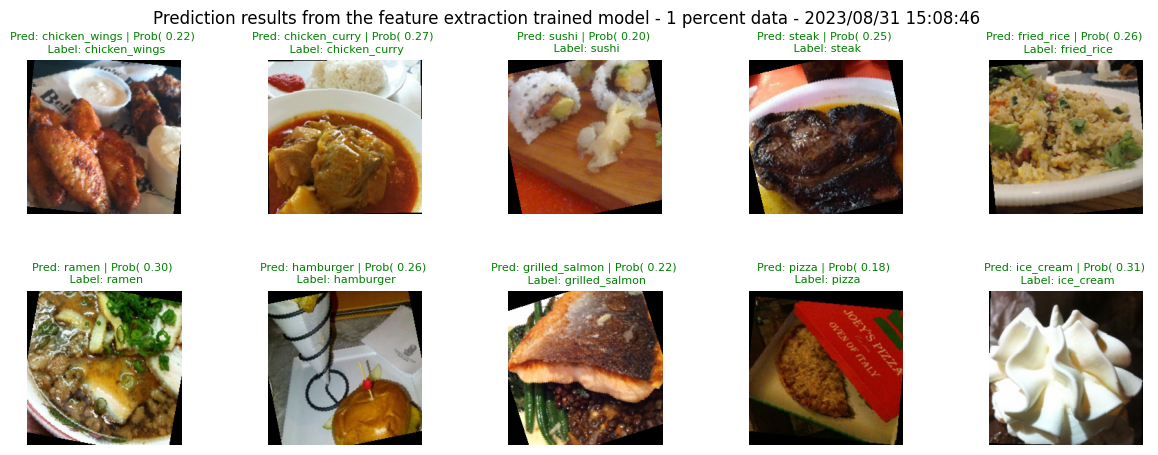

In [16]:
# one batch of val_dataloader
images, labels = next(iter(val_dataloader_1_percent))

logging.info(f"images.shape: {images.shape}")
logging.info(f"labels.shape: {labels.shape}")

# evaluate the model with val dataset
efficientnet_model_0.eval()
with torch.inference_mode():
    y_logits = efficientnet_model_0(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the feature extraction trained model - 1 percent data - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images):
    
    plt.subplot(2, len(images) // 2, i + 1)

    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    
    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
    
plt.savefig(PREDICTED_RESULTS_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH, bbox_inches="tight")

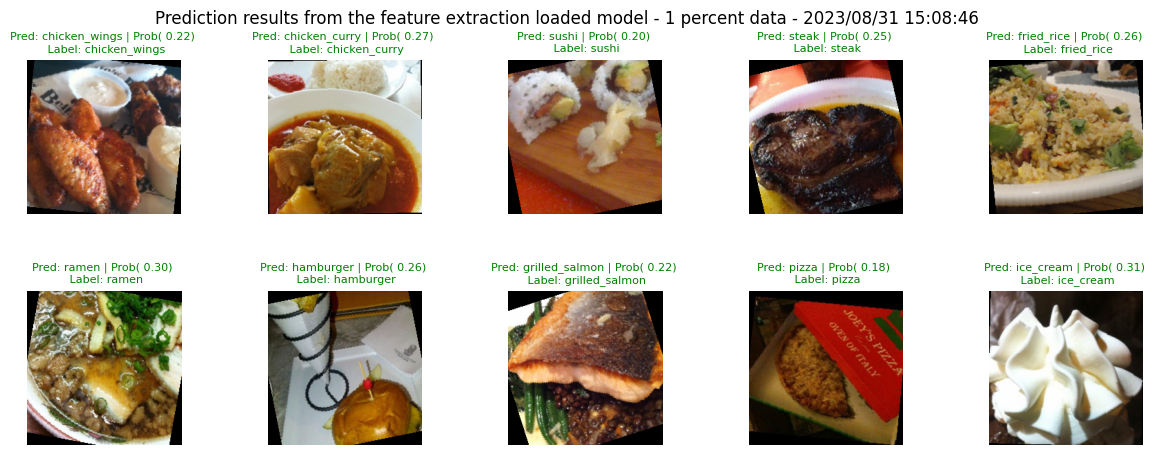

In [17]:
# load a trained model
loaded_model_0 = torch.load(f=MODEL_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH)

# evaluate the model with val dataset
loaded_model_0.eval()
with torch.inference_mode():
    y_logits = loaded_model_0(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the feature extraction loaded model - 1 percent data - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images):
    plt.subplot(2, len(images) // 2, i + 1)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)

    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
# _ = plt.show()
plt.savefig(PREDICTED_RESULTS_FEATURE_EXTRACTION_1_PERCENT_LOADED_FILE_PATH, bbox_inches="tight")

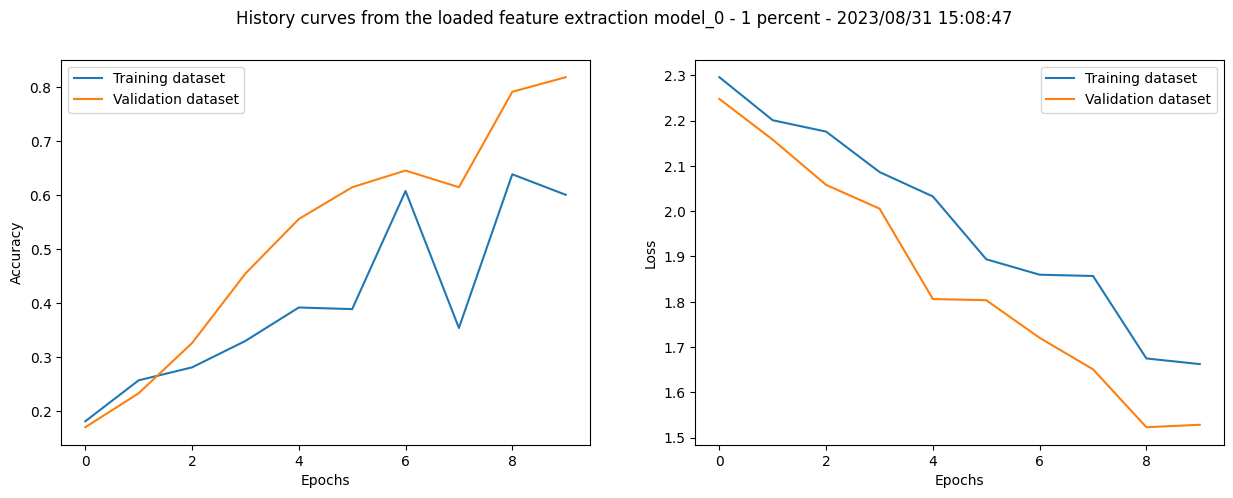

In [18]:
accuracy = history_dict_feature_extraction_1_percent["accuracy"]
loss = history_dict_feature_extraction_1_percent["loss"]
val_accuracy = history_dict_feature_extraction_1_percent["val_accuracy"]
val_loss = history_dict_feature_extraction_1_percent["val_loss"]

# plot history
plt.figure(figsize=(15, 5))
plt.suptitle(f"History curves from the loaded feature extraction model_0 - 1 percent - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplot(1, 2, 1)
plt.plot(list(range(len(accuracy))), accuracy, label="Training dataset")
plt.plot(list(range(len(val_accuracy))), val_accuracy, label="Validation dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss))), loss, label="Training dataset")
plt.plot(list(range(len(val_loss))), val_loss, label="Validation dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(HISTORY_CURVES_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH, bbox_inches="tight")

#### Fine-tuning - Transfer Learning

In [19]:
# load a trained model
loaded_model_0 = torch.load(f=MODEL_FEATURE_EXTRACTION_1_PERCENT_FILE_PATH)

# history dict
history_dict_feature_extraction_full_data = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": []
}

# create a model
efficientnet_model_1 = create_model(model=loaded_model_0, class_names=class_names, device=device, feature_extraction=False, fine_tuning=True)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=efficientnet_model_1.parameters(), lr= 0.0001) # 10x lower for fine-tuning

## TRAINING 
end_epochs = inital_epochs + 20
for epoch in range(inital_epochs, end_epochs):

    accumulated_train_loss = 0.0
    accumulated_train_accuracy = 0.0
    accumulated_train_batches = 0

    # execution time
    start_timer = timer()

    for inputs, outputs in train_dataloader_full_data:

        # training mode
        efficientnet_model_1.train()

        # send data to device
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        # forward 
        y_logits = efficientnet_model_1(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate accuracy
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += (acc / len(y_logits))

        # zero gradients
        optimizer.zero_grad()

        # backward 
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    
    ## EVALUATION
    # evaluation mode
    efficientnet_model_1.eval()
    with torch.inference_mode():
        
        accumulated_test_loss = 0.0
        accumulated_test_accuracy = 0.0
        accumulated_test_batches = 0

        for inputs, outputs in test_dataloader_full_data:

            # send data to device
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # forward 
            y_logits = efficientnet_model_1(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate accuracy
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1
    
     # execution time
    end_timer = timer()
    execution_time = end_timer - start_timer
    
    # training
    accuracy = accumulated_train_accuracy / accumulated_train_batches
    loss = accumulated_train_loss / accumulated_train_batches

    # evaluating
    val_accuracy = accumulated_test_accuracy / accumulated_test_batches
    val_loss = accumulated_test_loss / accumulated_test_batches

    # history dict
    history_dict_feature_extraction_full_data["accuracy"].append(round(accuracy, 3))
    history_dict_feature_extraction_full_data["loss"].append(round(loss.cpu().numpy().item(), 4))
    history_dict_feature_extraction_full_data["val_accuracy"].append(round(val_accuracy, 3))
    history_dict_feature_extraction_full_data["val_loss"].append(round(val_loss.cpu().numpy().item(), 4))

    # print out 
    logging.info(f"Epoch: {epoch + 1} / {end_epochs} | Execution time: {execution_time:.2f}s | accuracy: {accuracy: .3f} | loss: {loss: .4f} | val_accuracy: {val_accuracy: .3f} | val_loss: {val_loss: .4f} ")

# save model
torch.save(efficientnet_model_1, MODEL_FINE_TUNING_FULL_DATA_FILE_PATH)


[Thu, 31 Aug 2023, 15:08:48.010] INFO - Transfer Learning - Fine-tuning Mode
[Thu, 31 Aug 2023, 15:08:12.665] INFO - Epoch: 11 / 30 | Execution time: 24.65s | accuracy:  0.500 | loss:  1.6944 | val_accuracy:  0.796 | val_loss:  0.8266 
[Thu, 31 Aug 2023, 15:08:37.063] INFO - Epoch: 12 / 30 | Execution time: 24.40s | accuracy:  0.745 | loss:  0.8592 | val_accuracy:  0.864 | val_loss:  0.4757 
[Thu, 31 Aug 2023, 15:08:01.550] INFO - Epoch: 13 / 30 | Execution time: 24.49s | accuracy:  0.800 | loss:  0.6535 | val_accuracy:  0.876 | val_loss:  0.4220 
[Thu, 31 Aug 2023, 15:08:26.112] INFO - Epoch: 14 / 30 | Execution time: 24.56s | accuracy:  0.821 | loss:  0.5747 | val_accuracy:  0.884 | val_loss:  0.3621 
[Thu, 31 Aug 2023, 15:08:50.761] INFO - Epoch: 15 / 30 | Execution time: 24.65s | accuracy:  0.843 | loss:  0.4988 | val_accuracy:  0.898 | val_loss:  0.3298 
[Thu, 31 Aug 2023, 15:08:15.223] INFO - Epoch: 16 / 30 | Execution time: 24.46s | accuracy:  0.863 | loss:  0.4470 | val_accurac

[Thu, 31 Aug 2023, 15:08:11.462] INFO - images.shape: torch.Size([10, 3, 224, 224])
[Thu, 31 Aug 2023, 15:08:11.463] INFO - labels.shape: torch.Size([10])


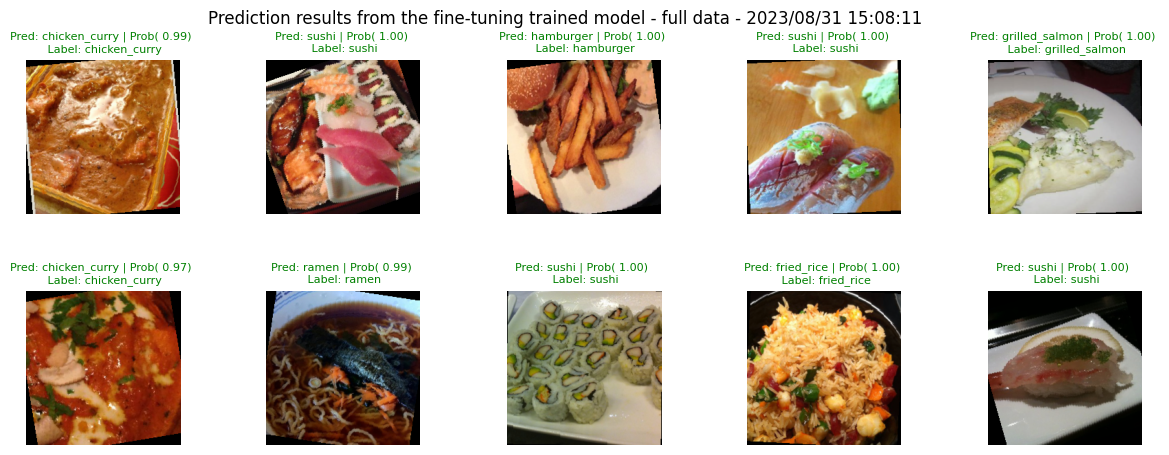

In [20]:
# one batch of val_dataloader
images, labels = next(iter(val_dataloader_full_data))
images, labels = images[:10], labels[:10]

logging.info(f"images.shape: {images.shape}")
logging.info(f"labels.shape: {labels.shape}")

# evaluate the model with val dataset
efficientnet_model_1.eval()
with torch.inference_mode():
    y_logits = efficientnet_model_1(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the fine-tuning trained model - full data - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images[:10]):
    plt.subplot(2, len(images) // 2, i + 1)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    
    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
    
plt.savefig(PREDICTED_RESULTS_FINE_TUNING_FULL_DATA_FILE_PATH, bbox_inches="tight")

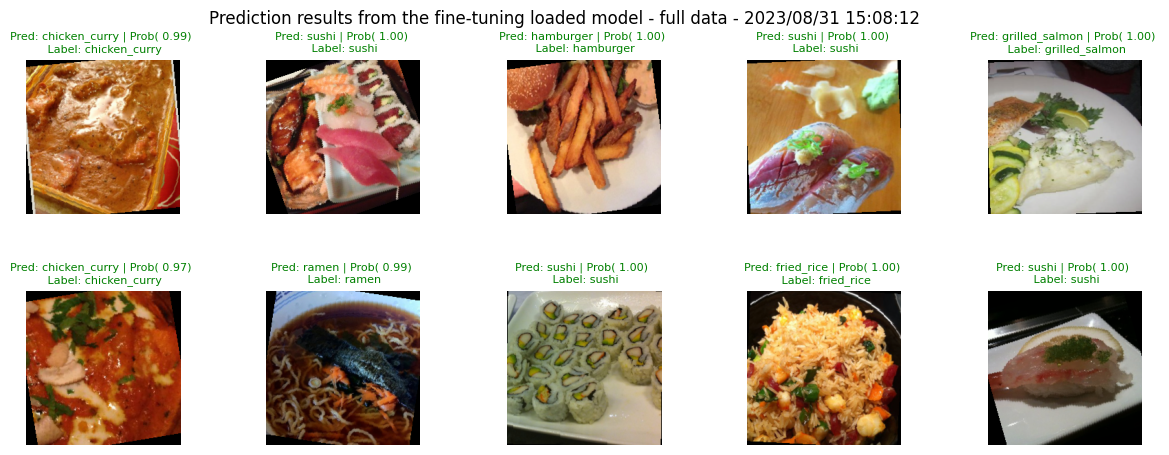

In [21]:
# load a trained model
loaded_model_1 = torch.load(f=MODEL_FINE_TUNING_FULL_DATA_FILE_PATH)

# evaluate the model with val dataset
loaded_model_1.eval()
with torch.inference_mode():
    y_logits = loaded_model_1(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the fine-tuning loaded model - full data - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images):
    plt.subplot(2, len(images) // 2, i + 1)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)

    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
# _ = plt.show()
plt.savefig(PREDICTED_RESULTS_FINE_TUNING_FULL_DATA_LOADED_FILE_PATH, bbox_inches="tight")

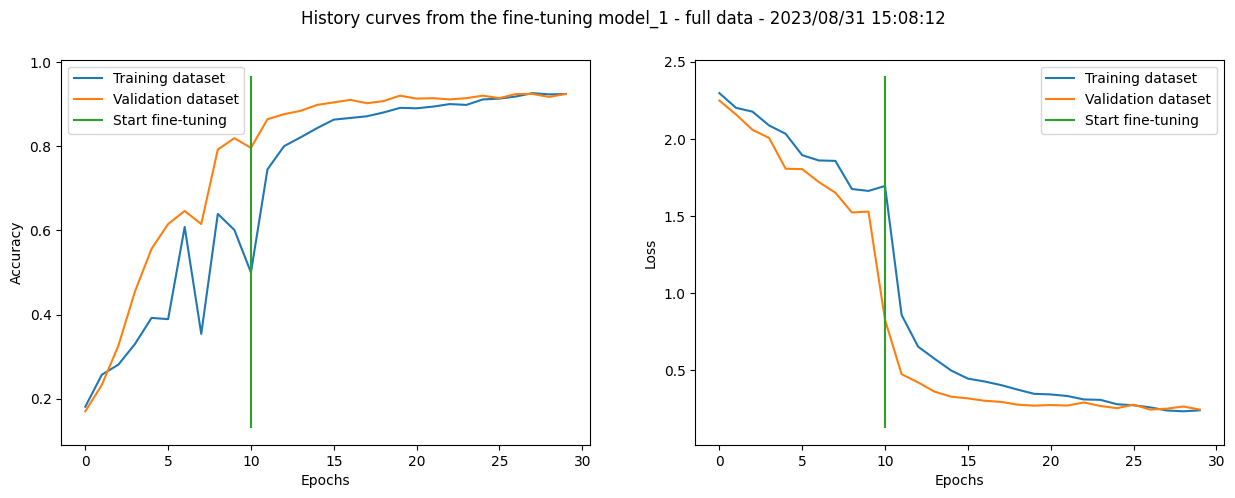

In [22]:
accuracy = history_dict_feature_extraction_1_percent["accuracy"] + history_dict_feature_extraction_full_data["accuracy"]
loss = history_dict_feature_extraction_1_percent["loss"] +  history_dict_feature_extraction_full_data["loss"]
val_accuracy = history_dict_feature_extraction_1_percent["val_accuracy"] +  history_dict_feature_extraction_full_data["val_accuracy"]
val_loss = history_dict_feature_extraction_1_percent["val_loss"] +  history_dict_feature_extraction_full_data["val_loss"]

# plot history
plt.figure(figsize=(15, 5))
plt.suptitle(f"History curves from the fine-tuning model_1 - full data - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplot(1, 2, 1)
plt.plot(list(range(len(accuracy))), accuracy, label="Training dataset")
plt.plot(list(range(len(val_accuracy))), val_accuracy, label="Validation dataset")
plt.plot([inital_epochs, inital_epochs], plt.ylim(), label = "Start fine-tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss))), loss, label="Training dataset")
plt.plot(list(range(len(val_loss))), val_loss, label="Validation dataset")
plt.plot([inital_epochs, inital_epochs ], plt.ylim(), label = "Start fine-tuning")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(HISTORY_CURVES_FINE_TUNING_FULL_DATA_FILE_PATH, bbox_inches="tight")